# Decision trees
#### on Teamfight Tactics, camera types and some Zurichs dogs datasets.

### Necessary libraries

In [3]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import tqdm
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from Tree import Tree
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LinearRegression

# graphviz PATH hotfix
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

apiKey = "##############################################"

## Teamfight Tacticts dataset

Main goal of this part is to predict that there are relations between in-game charackters and in what kind of composition, they winnability is the highest. The game is a variant od League of Legends, called Teamfight Tactits (TFT), which is turn based and non-deterministic. Players role is to compose set of characters, that beats other players compositions. Throughout the game, armies are getting bigger and characters are getting stronger. We will be covering final stage, when are units are available. Important information is, that each unit has some special traits, so collecting characters with same traits will benefit the player. Our plan is to find best combinations of 2-3 units that are the most succesful and after such classification, compare it to the traits.

Loading data, previously scrapped from RiotAPI and preprocessed.

In [4]:
with open('games.json') as games_scrapped_from_API:
    games_data = json.load(games_scrapped_from_API)

In [5]:
units3 = np.array(["", 0, 0])
for game in games_data:
    for i, squad in enumerate(game[:2]):
        for champ in squad:
            won = (i+1)%2
            units3 = np.vstack((units3,[champ[0],int(won),int(i)]))

In [6]:
units_c = pd.DataFrame(units3, columns=['Champion','Won', 'Lost'])
units_c.astype({'Won':'int32','Lost':'int32'}).dtypes
a = units_c.groupby(['Champion']).sum()

temp = np.array(a)
res = np.array([None, None])
for pair in temp:
    x = pair[0]
    y = pair[1]
    x = np.sum([int(i) for i in x])
    y = np.sum([int(i) for i in y])
    res = np.vstack((res, (x, y)))
    
formated_df = np.c_[np.array(a.index),res.T[0][1:],res.T[1][1:]]
formated_df = formated_df[1:]
units4 = pd.DataFrame(formated_df, columns=['Champion','Won', 'Lost'])
units4 = units4.sort_values(by=['Won'])

#### Decision Tree - algorithm taken from our earlier implementation, done for ML course. 

In [7]:
def TFT_data_preprocess(champions, data_json):
    df = pd.DataFrame(columns=champions+['target'], dtype=np.int8)
    for i, game in enumerate(data_json):
        winner, loser = game[0], game[1]
        winner_champs = [c[0] for c in winner]
        loser_champs  = [c[0] for c in loser]
        winner_row = np.empty(len(champions)+1, dtype=np.str)
        loser_row  = np.empty(len(champions)+1, dtype=np.str)
        winner_row.fill('f')
        loser_row.fill('f')
        winner_row[-1] = 1
        loser_row[-1] = 0
        for j, champion in enumerate(champions):
            if champion in winner_champs:
                winner_row[j] = 't'
            if champion in loser_champs:
                loser_row[j]  = 't'
        df.loc[2*i]   = winner_row
        df.loc[2*i+1] = loser_row
    return df
    
tft_df = TFT_data_preprocess(list(units4['Champion']), games_data)
tft_df.head()

Neeko Maokai Ivern Leblanc Veigar Diana Warwick Vayne Braum Malzahar  ...  \
0     f      f     f       f      f     f       f     f     f        f  ...   
1     f      f     f       t      f     f       f     f     f        f  ...   
2     f      f     f       f      f     f       f     f     f        f  ...   
3     f      f     f       f      f     f       f     f     f        f  ...   
4     f      f     f       f      f     f       f     f     f        f  ...   

  Qiyana Kindred Brand Nami Thresh Annie Yorick Malphite Nautilus target  
0      f       f     t    t      t     t      f        t        t      1  
1      f       f     t    f      t     f      f        t        t      0  
2      f       f     f    f      f     f      f        f        f      1  
3      f       f     f    t      f     f      f        f        f      0  
4      f       f     t    t      f     t      f        f        f      1  

[5 rows x 53 columns]

In [8]:
train = tft_df.sample(frac=0.8)
test  = tft_df.drop(train.index)
X_train = train.drop('target', axis=1)
X_test  =  test.drop('target', axis=1)
Y_train = train.target
Y_test  =  test.target

In [9]:
tft_tree = Tree(train)

In [10]:
tft_tree.draw()

### We're trying to predicit whenever compositions of champions wins with other composition, which means labeling to one of two classes {winner, looser}.

In [11]:
Y_predict = [tft_tree.classify(X_test.iloc[i]) for i in range(len(X_test))]
Y_predict = pd.Series(Y_predict)
Y_predict.index = Y_test.index
TFT_score = Y_predict==Y_test
print(f'Decision tree has {np.round(np.array(TFT_score.value_counts())[1]/ len(Y_test) * 100, 2)} % accuracy')

Decision tree has 48.68 % accuracy


### Confusion matrix tells the story.

In [12]:
confusion_matrix(Y_test, Y_predict)

array([[358, 393],
       [346, 343]], dtype=int64)

### Same decision tree, but prunned with confidence interval prunning.

Confidence interval prunning will prune node only if it reduces estimated error rate.

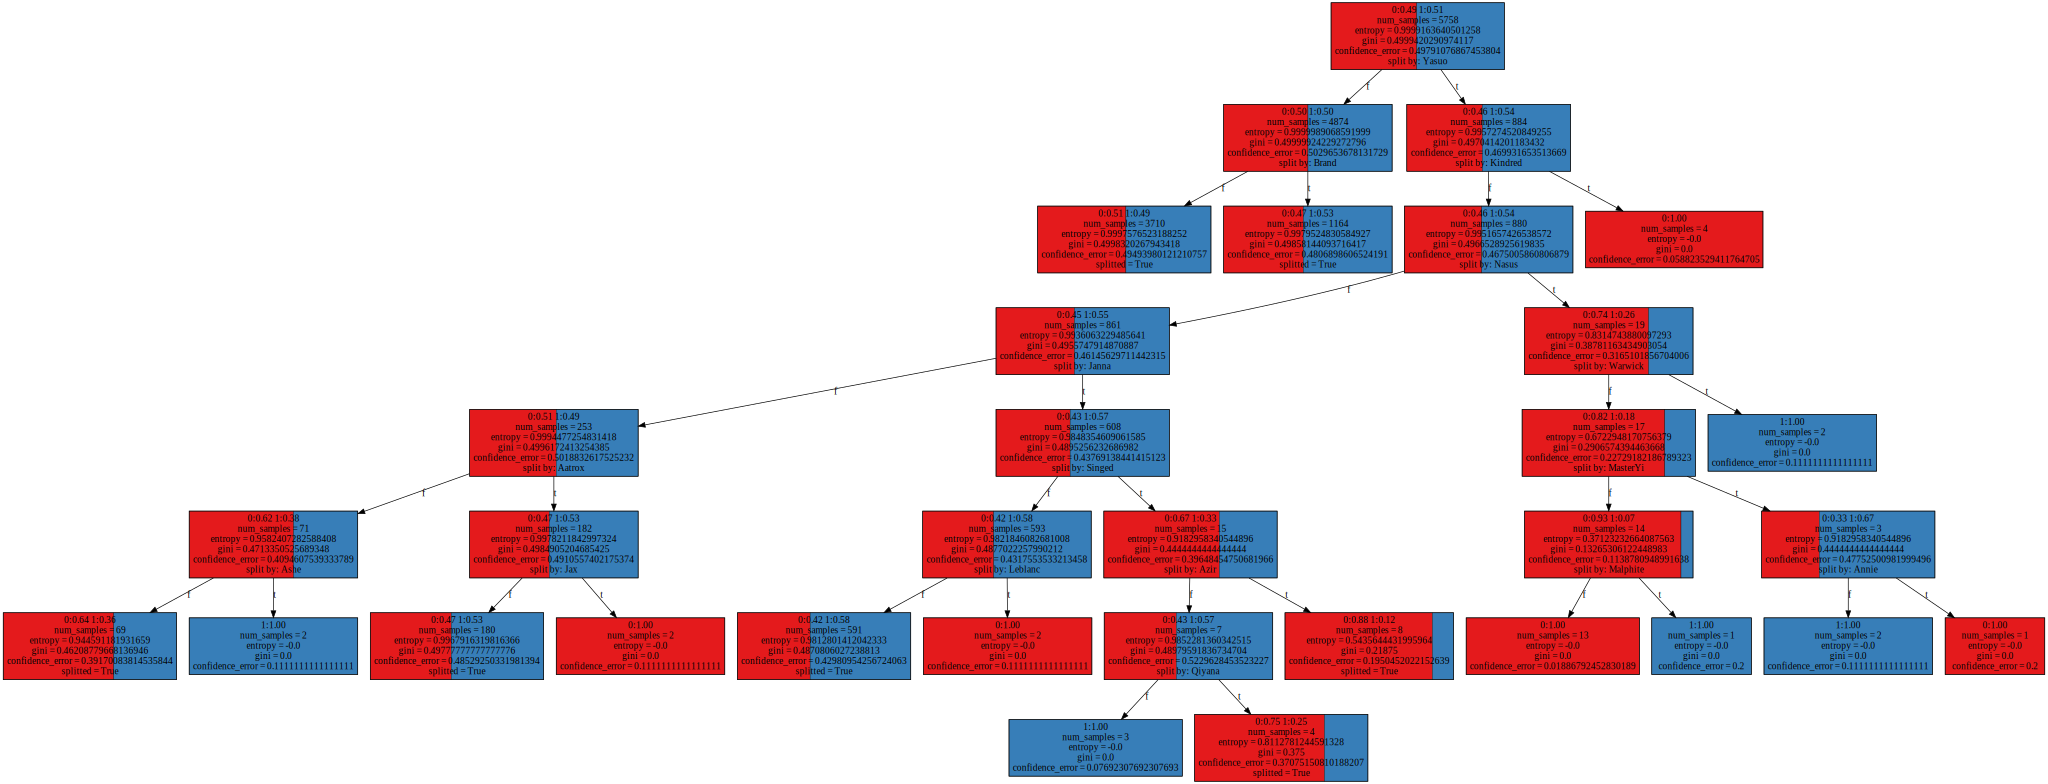

In [13]:
tft_tree.confidence_interval_pruning()
tft_tree.draw()

In [14]:
Y_predict = [tft_tree.classify(X_test.iloc[i]) for i in range(len(X_test))]
Y_predict = pd.Series(Y_predict)
Y_predict.index = Y_test.index
TFT_score = Y_predict==Y_test
print(f'Prunned decision tree has {np.round(np.array(TFT_score.value_counts())[1]/ len(Y_test) * 100, 2)} % accuracy')

Prunned decision tree has 49.93 % accuracy


In [15]:
confusion_matrix(Y_test, Y_predict)

array([[487, 264],
       [455, 234]], dtype=int64)

In [16]:
# plt.subplots(figsize=(16,9))
# sns.barplot(x='Champion',y='Won', data=units4)
# plt.xticks(rotation=90)
# plt.show()

#### Decision trees did not succeed because we picked the best players, that expliot game strategies to the maximum. In this case, they are all playing currently the best champions and diferences between winners and loosers are to small to predict anything.
#### That observation can be seen on the plot below.

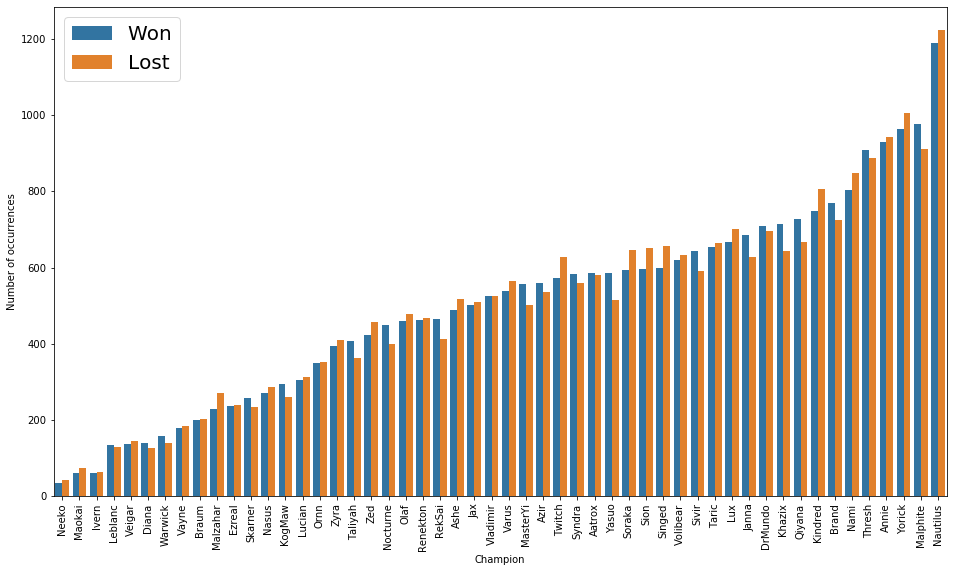

In [17]:
plt.subplots(figsize=(16,9))
units_melted = pd.melt(units4, id_vars=units4.columns[0], var_name="Verdict", value_name="Number of occurrences")
sns.barplot(x=units4.columns[0], y="Number of occurrences", hue="Verdict", data=units_melted)
plt.xticks(rotation=90)
plt.legend(loc=2, prop={'size': 20})
plt.show()

In [18]:
units_to_arr = np.array(units4)
units_wl = np.array([str(units_to_arr[0][0]), np.round(int(units_to_arr[0][1])/(int(units_to_arr[0][1]) + int(units_to_arr[0][2]))*100, 2)])
units_to_arr = np.array(units4)[1:]

for i in range(len(units_to_arr)):
    units_wl = np.vstack((units_wl, [str(units_to_arr[i][0]), np.round(int(units_to_arr[i][1])/(int(units_to_arr[i][1]) + int(units_to_arr[i][2]))*100, 2)]))

units_wl_df = pd.DataFrame(units_wl, columns=['Champion','Winratio'])

In [19]:
units_wl_df['Winratio'] = units_wl_df['Winratio'].apply(pd.to_numeric, errors='coerce')
units_wl_df = units_wl_df.sort_values(by=['Winratio'])

#### Win ratio also proves that statement. There are none overpowered champions, which implies that there are also none superior combionations of them.

#### We are not able to provide any breaking results, but at leasts we've proven, that game is pretty balanced.

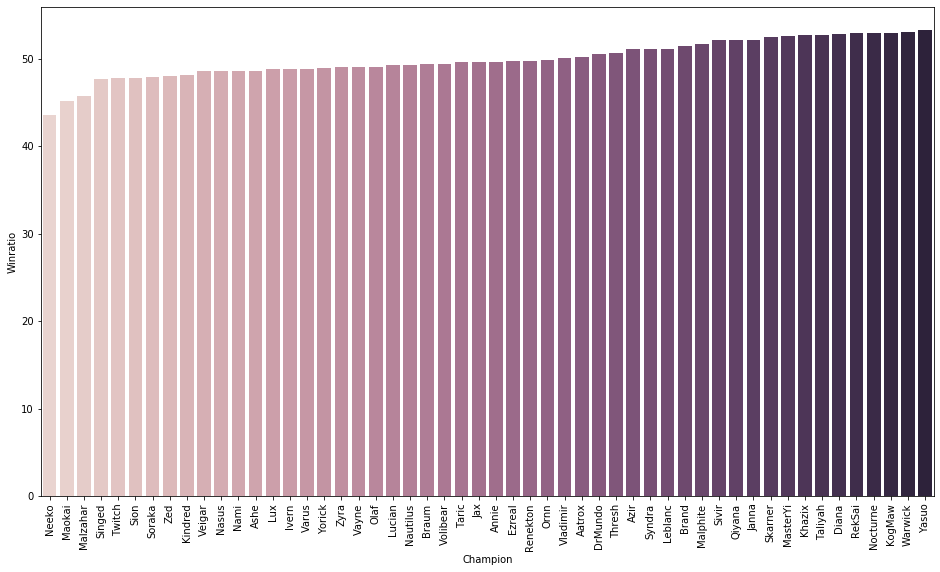

In [20]:
plt.subplots(figsize=(16,9))
sns.barplot(x='Champion',y='Winratio', data=units_wl_df, palette=sns.cubehelix_palette(len(units_wl_df.index)))
plt.xticks(rotation=90)
plt.show()

# Teamfight tactics dataset, but from another angle
We get matches from several different divisions (player from certain division is playing better\worse). Based on champions and synergies chosen and damage dealt to other players during single game, we try to predict whenever it's a player from bottom of the ladder or from the top. We have best and worst games from leagues such as iron(I), bronze(I), silver(I), gold(I), platinum(I) and diamond(I).

#### Firstly, we preprocessed the data aquired from API to have relevant statistics and to include only useful characteristics.

In [21]:
with open('data/iron1.json') as f:
    data_json = json.load(f)
champions_names = set()
traits_names = set()
for game in data_json:
    for i in range(0,len(game),4):
        champions = game[i]
        traits = game[i+1]
        dps = game[i+2]
        for champion in champions:
            champions_names.add(champion[0])
        for tr in traits:
            traits_names.add(tr[0])
                
champions_names = list(champions_names)
traits_names = list(traits_names)
champions_names = [str(name)[5:] for name in champions_names]
traits_names = [str(name)[5:] if 'Set2_' in str(name) else name for name in traits_names]

In [22]:
def prepare_data(data_json, champions_names, traits_names, division):
    df = pd.DataFrame(columns=champions_names+traits_names+['dps']+['won']+['lost']+['target'], dtype=np.float32)
    for i, game in enumerate(data_json):
        
        for k in range(len(game)):
            if k % 4 == 3:
                if game[k] == 1:
                    win_index = k
                elif game[k] == 8:
                    lose_index = k
        # WON
        
        won_champions = game[win_index-3]
        won_traits = game[win_index-2]
        won_dps = game[win_index-1]

        won_champions = [c[0] for c in won_champions]    
        won_traits_nr = [np.round(c[2]/c[3]*100,0) for c in won_traits]
        won_traits = [c[0] for c in won_traits]

        won_traits = [str(name)[5:] if 'Set2_' in str(name) else name for name in won_traits]
        won_champions = [str(name)[5:] for name in won_champions]
        
        won_row = np.empty(len(champions_names)+len(traits_names)+4, dtype=np.int)
        won_row.fill(0)
    
        # LOST
    
        lost_champions = game[lose_index-3]
        lost_traits = game[lose_index-2]
        lost_dps = game[lose_index-1]

        lost_row = np.empty(len(champions_names)+len(traits_names)+4, dtype=np.int)
        lost_row.fill(0)

        lost_champions = [c[0] for c in lost_champions]    
        lost_traits_nr = [np.round(c[2]/c[3]*100,0) for c in lost_traits]
        lost_traits = [c[0] for c in lost_traits]

        lost_traits = [str(name)[5:] if 'Set2_' in str(name) else name for name in lost_traits]
        lost_champions = [str(name)[5:] for name in lost_champions]

        

        for j, champion in enumerate(champions_names):
            if champion in won_champions:
                won_row[j] = 1
            if champion in lost_champions:
                lost_row[j] = 1

        for j, trait in enumerate(traits_names):
            if trait in won_traits:
                won_row[len(champions_names)+j] = won_traits_nr[won_traits.index(trait)]
            if trait in lost_traits:
                lost_row[len(champions_names)+j] = lost_traits_nr[lost_traits.index(trait)]

        won_row[len(champions_names)+len(traits_names)] = won_dps
        lost_row[len(champions_names)+len(traits_names)] = lost_dps

        won_row[len(champions_names)+len(traits_names)+1] = 1
        won_row[len(champions_names)+len(traits_names)+2] = 0

        lost_row[len(champions_names)+len(traits_names)+1] = 0
        lost_row[len(champions_names)+len(traits_names)+2] = 1

        won_row[len(champions_names)+len(traits_names)+3] = 0
        lost_row[len(champions_names)+len(traits_names)+3] = 0


        df.loc[2*i]   = won_row
        df.loc[2*i+1] = lost_row
    df['target'] = division
    return df

That's how loaded dataset looks like. First columns are champions, then there are columns with synergies given by $$\text{synergies} = \frac{\text{owned champions with that synergy}}{\text{possible champions of that synergy}} * 100$$ Next, there is damage dealt to other players during the game and flag, whenever its lost or won one.

In [23]:
iron1_df = prepare_data(data_json, champions_names, traits_names, 'iron1')
iron1_df.sample(3)

LuxWoodland  Aatrox  Varus  LeBlanc  Ornn  Neeko  Lucian  Zyra  Renekton  \
198          0.0     1.0    0.0      0.0   0.0    0.0     1.0   0.0       0.0   
729          0.0     0.0    0.0      0.0   0.0    1.0     0.0   0.0       0.0   
529          0.0     0.0    0.0      0.0   1.0    0.0     0.0   0.0       0.0   

     LuxGlacial  ...  Celestial  Wind  Blademaster  Warden  Glacial  Shadow  \
198         0.0  ...        0.0   0.0          0.0     0.0      0.0     0.0   
729         0.0  ...        0.0   0.0          0.0    33.0     33.0     0.0   
529         0.0  ...        0.0   0.0          0.0    33.0     67.0     0.0   

       dps  won  lost  target  
198  170.0  1.0   0.0   iron1  
729   23.0  0.0   1.0   iron1  
529   16.0  0.0   1.0   iron1  

[3 rows x 99 columns]

In [24]:
with open('data/bronze1.json') as f:
    bronze1_data = json.load(f)
    
bronze1_df = prepare_data(bronze1_data, champions_names, traits_names, 'bronze1')

with open('data/silver1.json') as f:
    silver1_data = json.load(f)
    
silver1_df = prepare_data(silver1_data, champions_names, traits_names, 'silver1')

with open('data/gold1.json') as f:
    gold1_data = json.load(f)
    
gold1_df = prepare_data(gold1_data, champions_names, traits_names, 'gold1')

with open('data/plat1.json') as f:
    plat1_data = json.load(f)
    
plat1_df = prepare_data(plat1_data, champions_names, traits_names, 'plat1')

with open('data/diamond1.json') as f:
    diamond1_data = json.load(f)
    
diamond1_df = prepare_data(diamond1_data, champions_names, traits_names, 'diamond1')

multidiv_df = plat1_df.append(gold1_df).append(silver1_df).append(bronze1_df).append(iron1_df).append(diamond1_df)
multidiv_df.reset_index(inplace=True)
multidiv_df.sample(5)

index  LuxWoodland  Aatrox  Varus  LeBlanc  Ornn  Neeko  Lucian  Zyra  \
4746    786          0.0     0.0    0.0      1.0   0.0    0.0     0.0   0.0   
4518    558          0.0     0.0    0.0      0.0   0.0    0.0     0.0   0.0   
2807    807          0.0     0.0    0.0      0.0   0.0    0.0     0.0   0.0   
1246    246          0.0     0.0    0.0      0.0   0.0    0.0     0.0   0.0   
221     221          0.0     0.0    0.0      0.0   0.0    0.0     0.0   0.0   

      Renekton  ...  Celestial  Wind  Blademaster  Warden  Glacial  Shadow  \
4746       0.0  ...        0.0   0.0          0.0    33.0      0.0     0.0   
4518       1.0  ...        0.0   0.0         33.0    33.0    100.0     0.0   
2807       0.0  ...        0.0   0.0          0.0     0.0    100.0     0.0   
1246       1.0  ...        0.0   0.0          0.0     0.0     33.0     0.0   
221        0.0  ...      100.0   0.0          0.0    67.0     33.0     0.0   

        dps  won  lost   target  
4746  190.0  1.0   0.0    iron1  
4518  194.0  1.0   0.0    iron1  
2807    4.0  0.0   1.0  silver1  
1246  169.0  1.0   0.0    gold1  
221    37.0  0.0   1.0    plat1  

[5 rows x 100 columns]

#### After appending them all together, we reset indexes to decorrelate the data from it's indexes.

In [25]:
multidiv_train = multidiv_df.sample(frac=0.8)
multidiv_test  = multidiv_df.drop(multidiv_train.index)
multidiv_X_train = multidiv_train.drop('target', axis=1)
multidiv_X_test  =  multidiv_test.drop('target', axis=1)
multidiv_Y_train = multidiv_train.target
multidiv_Y_test  =  multidiv_test.target 

In [26]:
multidiv_tree = Tree(multidiv_train)

In [27]:
multidiv_Y_predict = [multidiv_tree.classify(multidiv_X_test.iloc[i]) for i in range(len(multidiv_X_test))]
multidiv_Y_predict = pd.Series(multidiv_Y_predict)
multidiv_Y_predict.index = multidiv_Y_test.index
multidiv_good = multidiv_Y_predict == multidiv_Y_test
multidiv_good.value_counts()
confusion_matrix(multidiv_Y_test, multidiv_Y_predict)

array([[33, 18, 29, 33, 27, 28],
       [23, 59, 30, 13, 55, 33],
       [36, 26, 26, 30, 40, 50],
       [40,  7, 25, 45, 22, 39],
       [23, 47, 37, 20, 53, 29],
       [28, 22, 29, 36, 28, 43]], dtype=int64)

In [28]:
print(f' Accuracy on that data set is {np.round((multidiv_good.value_counts()[1] + multidiv_good.value_counts()[0])/multidiv_good.value_counts()[1], 2)} %')

 Accuracy on that data set is 4.49 %


Final score and confusion matrix are very poor. That's mostly because very commonly some compositions are made by random. Well exiperienced player may pick something on purpose, because he knows its value and on the other hand, weak player may choose the same option because randomly generated set of 5 cards forced him to do so. Since Riot's API doesn't allow us to see what kind of decisions players made during the game, we can only try to classify by the last arena fight they fought.

# Camera types dataset

Continuous and floating points data.

In [29]:
def load_and_clear_cameras_data():
    df = pd.read_csv('cameras.csv')
    df.dropna(inplace=True) # dropping only 2 rows
    df.drop(df[df['Low resolution'] == 0.0].index, inplace=True) # dropping 50 rows
    df.drop(df[df['Weight (inc. batteries)'] == 0.0].index, inplace=True) # dropping 19 rows
    df.drop(df[df['Dimensions'] == 0.0].index, inplace=True) # dropping 3 rows
    df.drop('Model', axis=1, inplace=True)
    return df

cameras_df = load_and_clear_cameras_data()
cameras_df.head()

Release date  Max resolution  Low resolution  Effective pixels  \
0          1997          1024.0           640.0               0.0   
1          1998          1280.0           640.0               1.0   
4          1999          1152.0           640.0               0.0   
5          2001          1600.0           640.0               1.0   
8          1996           832.0           640.0               0.0   

   Zoom wide (W)  Zoom tele (T)  Normal focus range  Macro focus range  \
0           38.0          114.0                70.0               40.0   
1           38.0          114.0                50.0                0.0   
4           43.0           43.0                50.0                0.0   
5           51.0           51.0                50.0               20.0   
8           50.0           50.0                40.0               10.0   

   Storage included  Weight (inc. batteries)  Dimensions   Price  
0               4.0                    420.0        95.0   179.0  
1               4.0                    420.0       158.0   179.0  
4              40.0                    300.0       128.0  1299.0  
5               8.0                    270.0       119.0   179.0  
8               1.0                    460.0       160.0   139.0

In [30]:
train_cam = cameras_df.sample(frac=0.8)
test_cam  = cameras_df.drop(train_cam.index)
X_train_cam = train_cam.drop('Price', axis=1)
X_test_cam  =  test_cam.drop('Price', axis=1)
Y_train_cam = train_cam.Price
Y_test_cam  =  test_cam.Price

print(f'Features: {list(cameras_df.columns)}')

Features: ['Release date', 'Max resolution', 'Low resolution', 'Effective pixels', 'Zoom wide (W)', 'Zoom tele (T)', 'Normal focus range', 'Macro focus range', 'Storage included', 'Weight (inc. batteries)', 'Dimensions', 'Price']


### Let's try to predict the price given all other values. To do so, let's use Decision Trees Classifier.

In [31]:
print(f'All price classes: \n{np.unique(train_cam.Price)}')

All price classes: 
[  14.   19.   62.   99.  119.  126.  129.  139.  146.  149.  159.  169.
  177.  179.  199.  229.  249.  269.  299.  329.  384.  399.  429.  449.
  499.  509.  549.  599.  799. 1199. 1299. 1399. 1499. 1599. 1699. 1799.
 4499. 4699. 4999. 7999.]


In [32]:
dtc_cameras = DecisionTreeClassifier()
dtc_cameras.fit(X_train_cam, Y_train_cam)
print(f'Mean accuracy of the test set is {np.round(dtc_cameras.score(X_test_cam, Y_test_cam)*100,2)} %')
# Intuitily np.round(np.count_nonzero(dtc_cameras.predict(X_test_cam) == Y_test_cam)/len(Y_test_cam) * 100,2)

Mean accuracy of the test set is 41.15 %


### When it comes to prediciting floating point values, we can use Decision Tree Regressor.

In [33]:
dtr = DecisionTreeRegressor(min_samples_leaf=12)
dtr.fit(X_train_cam, Y_train_cam)
print(f'Score of the test set on DecisionTreeRegressor is {np.round(dtr.score(X_test_cam, Y_test_cam),2)}')
print(f'')
# print(np.count_nonzero(dtr.predict(X_test_cam) == Y_test_cam))

Score of the test set on DecisionTreeRegressor is 0.58



### In Decision Tree Regressor, score is coefficient of determination R^2 of the prediction. Our own implementation is presented below.

### The closer to 0, the better.

In [34]:
def coefficient_of_determination(the_tree, X_test, Y_test):
    u = ((the_tree.predict(X_test) - Y_test)**2).sum()
    v = ((Y_test - Y_test.mean()) ** 2).sum()
    return 1 - u/v

print(np.round(coefficient_of_determination(dtr, X_test_cam, Y_test_cam),2) == np.round(dtr.score(X_test_cam, Y_test_cam),2))

True


In [35]:
LR = LinearRegression()
LR.fit(X_train_cam, Y_train_cam)
LR.score(X_test_cam, Y_test_cam)*100

52.729434855182745

In [36]:
coef_R2 = np.array([np.round(coefficient_of_determination(dtr, X_test_cam, Y_test_cam),2),
                    np.round(coefficient_of_determination(dtc_cameras, X_test_cam, Y_test_cam),2),
                   np.round(coefficient_of_determination(LR, X_test_cam, Y_test_cam),2)])

mean_pred_acc = np.array([np.round(np.count_nonzero(dtr.predict(X_test_cam) == Y_test_cam)/len(Y_test_cam) * 100,2),
                         np.round(np.count_nonzero(dtc_cameras.predict(X_test_cam) == Y_test_cam)/len(Y_test_cam) * 100,2),
                         np.round(np.count_nonzero(LR.predict(X_test_cam) == Y_test_cam)/len(Y_test_cam) * 100,2)])

red_cla_comp = np.vstack((coef_R2, mean_pred_acc))
regressor_classifier_comparison = pd.DataFrame(red_cla_comp, columns=['Regressor','Classifier', 'Linear Regression'])
# regressor_classifier_comparison = pd.DataFrame({'Regressor':[coef_R2[1],mean_pred_acc[1]],'Classifier':[coef_R2[0],mean_pred_acc[0]]})
regressor_classifier_comparison.head()

Regressor  Classifier  Linear Regression
0       0.58        0.47               0.53
1       0.00       41.15               0.00

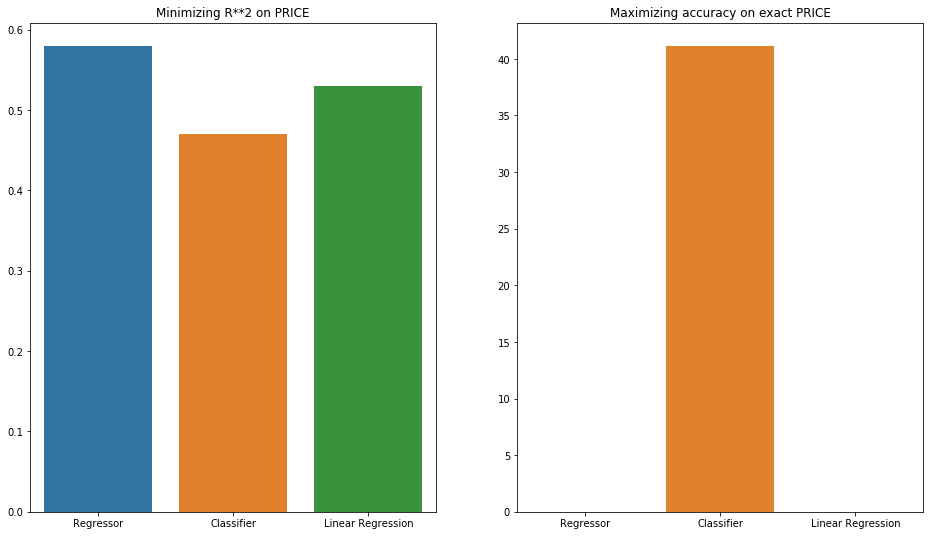

In [37]:
f, axes = plt.subplots(1,2, figsize=(16,9))
axes[0].title.set_text('Minimizing R**2 on PRICE')
axes[1].title.set_text('Maximizing accuracy on exact PRICE')
sns.barplot(['Regressor', 'Classifier', 'Linear Regression'], coef_R2, ax=axes[0])
sns.barplot(['Regressor', 'Classifier', 'Linear Regression'], mean_pred_acc, ax=axes[1])
plt.show()

In [38]:
train_cam2 = cameras_df.sample(frac=0.8)
test_cam2  = cameras_df.drop(train_cam.index)
X_train_cam2 = train_cam2.drop('Release date', axis=1)
X_test_cam2  =  test_cam2.drop('Release date', axis=1)
Y_train_cam2 = train_cam2['Release date']
Y_test_cam2  =  test_cam2['Release date']

dtc_cameras2 = DecisionTreeClassifier()
dtc_cameras2.fit(X_train_cam2, Y_train_cam2)
print(f'Mean accuracy of the test set is {np.round(dtc_cameras2.score(X_test_cam2, Y_test_cam2)*100,2)} %')

dtr2 = DecisionTreeRegressor(min_samples_leaf=12)
dtr2.fit(X_train_cam2, Y_train_cam2)
print(f'Score of the test set on DecisionTreeRegressor is {np.round(dtr2.score(X_test_cam2, Y_test_cam2),2)}')

Mean accuracy of the test set is 86.46 %
Score of the test set on DecisionTreeRegressor is 0.86


In [39]:
LR2 = LinearRegression()
LR2.fit(X_train_cam2, Y_train_cam2)
LR2.score(X_test_cam2, Y_test_cam2)*100

81.17187519575269

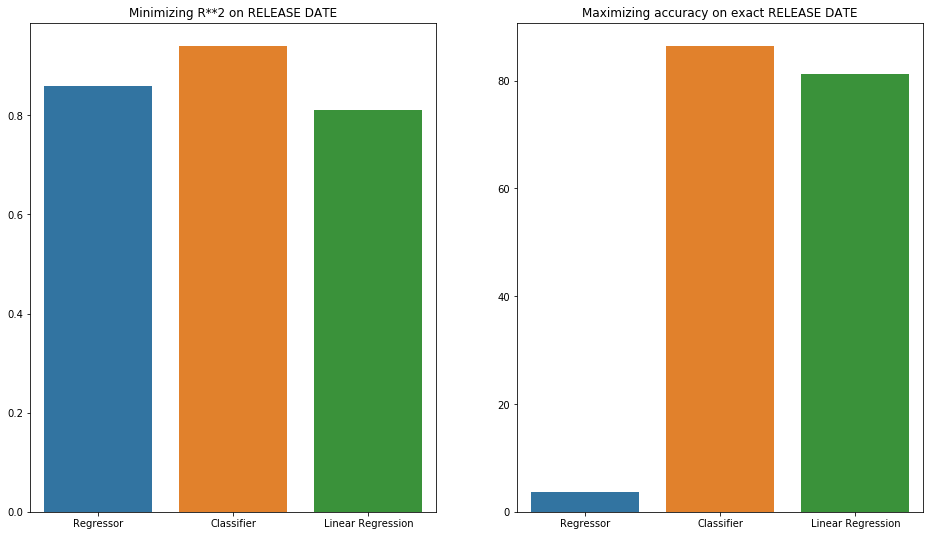

In [40]:
coef_R2_2 = np.array([np.round(coefficient_of_determination(dtr2, X_test_cam2, Y_test_cam2),2),
                    np.round(coefficient_of_determination(dtc_cameras2, X_test_cam2, Y_test_cam2),2),
                     np.round(coefficient_of_determination(LR2, X_test_cam2, Y_test_cam2),2)])

mean_pred_acc_2 = np.array([np.round(np.count_nonzero(dtr2.predict(X_test_cam2) == Y_test_cam2)/len(Y_test_cam2) * 100,2),
                         np.round(np.count_nonzero(dtc_cameras2.predict(X_test_cam2) == Y_test_cam2)/len(Y_test_cam2) * 100,2),
                           np.round(LR2.score(X_test_cam2, Y_test_cam2)*100,2)])

f, axes = plt.subplots(1,2, figsize=(16,9))
axes[0].title.set_text('Minimizing R**2 on RELEASE DATE')
axes[1].title.set_text('Maximizing accuracy on exact RELEASE DATE')
sns.barplot(['Regressor', 'Classifier', 'Linear Regression'], coef_R2_2, ax=axes[0])
sns.barplot(['Regressor', 'Classifier', 'Linear Regression'], mean_pred_acc_2, ax=axes[1])
plt.show()

### Conclusion: there is no golden mean, when chosing between Regressor and Classifier, on floating points or similarly continuous data.
Linear regression and Decision Tree Regressor works worse than Decision Tree Classfier when looking for exact data classes.

### Decision Tree Classifier with class prior probability.

(array([ 11.,  26.,  45.,  55.,  79.,  84.,  89., 133., 139., 300.]),
 array([1996. , 1997.1, 1998.2, 1999.3, 2000.4, 2001.5, 2002.6, 2003.7,
        2004.8, 2005.9, 2007. ]),
 <a list of 10 Patch objects>)

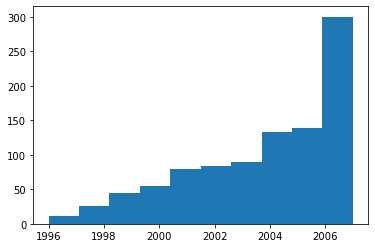

In [41]:
plt.hist(cameras_df["Release date"])

In [46]:
dtc_prior = DecisionTreeClassifier(class_weight={1996: 30, 1997: 14, 1998: 14, 1999: 9, 2000: 8, 2001: 8, 2002: 8, 2003: 4, 2004: 4, 2005: 2, 2006: 2, 2007: 1} )
dtc_prior.fit(X_train_cam2, Y_train_cam2)
score_prior = np.round(dtc_prior.score(X_test_cam2, Y_test_cam2) * 100,2)
print(f'Accuracy for normal tree: {np.round(dtc_cameras2.score(X_test_cam2, Y_test_cam2)*100,2)}')
print(f'Accuracy for tree with class weighted: {score_prior}')


Accuracy for normal tree: 86.46
Accuracy for tree with class weighted: 86.46
